In [7]:
import glob
from datasets.segdataset import SegData, DynnetData, DynnetEval
from models.seg import CustomSeg
from utils_dir.backbones_utils import load_backbone
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import torchvision.transforms as transforms
from skimage import exposure
import segmentation_models_pytorch as smp

### Check SegData

In [3]:
data_dir = '/home/gridsan/manderson/ovdsat/data/monthly_dynnet/train'
dataobj = SegData(data_dir)

In [4]:
# Rescale surface reflectance values for plotting with color balance
def rescale(img, low=1, high=99):
    p_low, p_high = np.percentile(img, (low, high))
    return exposure.rescale_intensity(img, in_range=(p_low, p_high))

In [5]:
titles = ['RGB', 'impervious surface', 'agriculture', 'forest & other vegetation', 'wetlands', 'soil', 'water', 'snow & ice']

/home/gridsan/manderson/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


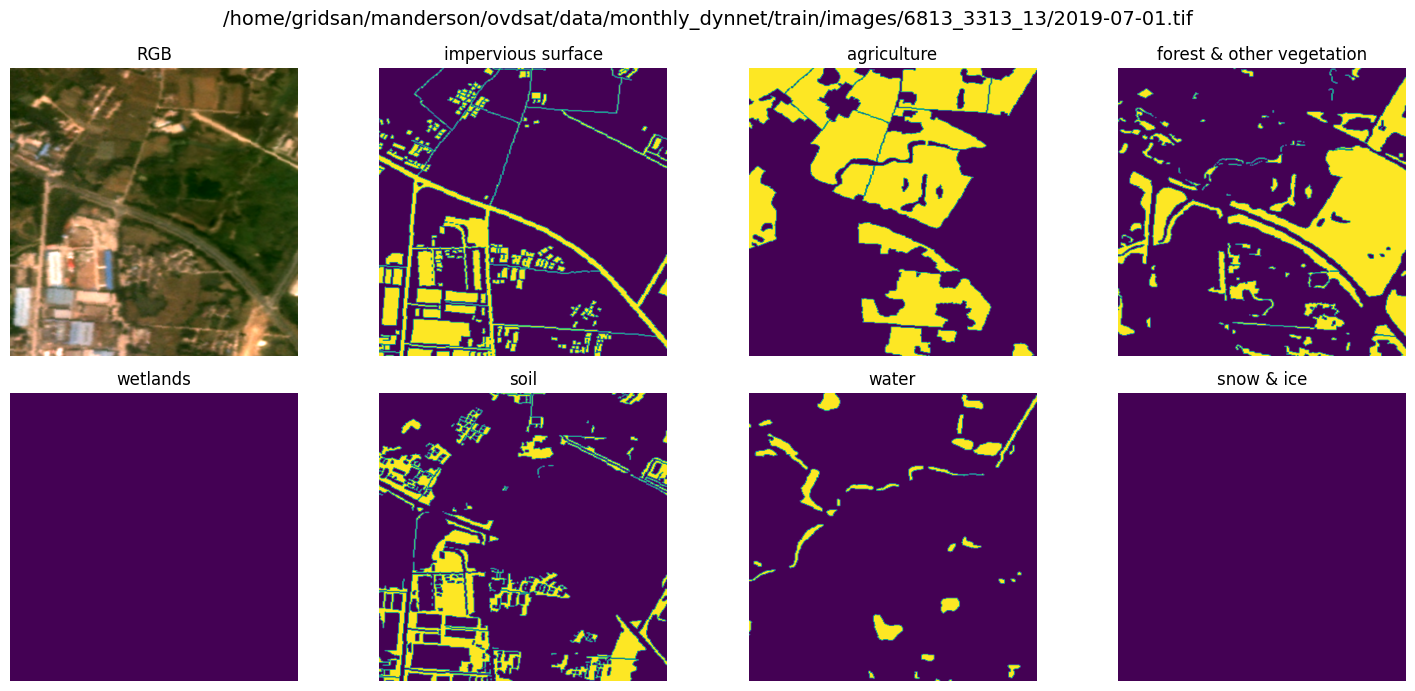

In [6]:
rand_idx = random.randint(0, len(dataobj))

img, mask = dataobj[rand_idx]
#rgb = np.array(np.transpose(img[:-1,:,:], (1, 2, 0)))
rgb = np.array(np.dstack((img[2], img[1], img[0])))
norm_rgb = (rgb - rgb.min())/(rgb.max() - rgb.min())
rs_rgb = rescale(norm_rgb)

# Create a 2x4 grid for the images
fig, axes = plt.subplots(2, 4, figsize=(15, 7))  # Adjust figure size as needed

# Plot each image
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(rs_rgb)
    else:
        ax.imshow(mask[i-1])
    ax.set_title(titles[i], fontsize=12)
    ax.axis('off')  # Hide axis
    
plt.suptitle(dataobj.get_id(rand_idx)[0], fontsize=14)
plt.tight_layout()
plt.show()

### Check DynnetData

In [13]:
train_split = '/home/gridsan/manderson/ovdsat/data/monthly_dynnet/splits/train_split_10-1.txt'
val_split = '/home/gridsan/manderson/ovdsat/data/monthly_dynnet/splits/val_split_10-1.txt'

train_data = DynnetData(train_split)
val_data = DynnetData(val_split)

print(len(train_data))
print(len(val_data))

print(train_data.samples[0])
print(val_data.samples[0])

168
72
['/home/gridsan/manderson/ovdsat/data/monthly_dynnet/train/images/1311_3077_13/2018-01-01.tif', '/home/gridsan/manderson/ovdsat/data/monthly_dynnet/train/labels/1311_3077/2018-01-01.tif']
['/home/gridsan/manderson/ovdsat/data/monthly_dynnet/train/images/2029_3764_13/2018-01-01.tif', '/home/gridsan/manderson/ovdsat/data/monthly_dynnet/train/labels/2029_3764/2018-01-01.tif']


In [14]:
titles = ['RGB', 'impervious surface', 'agriculture', 'forest & other vegetation', 'wetlands', 'soil', 'water', 'snow & ice']

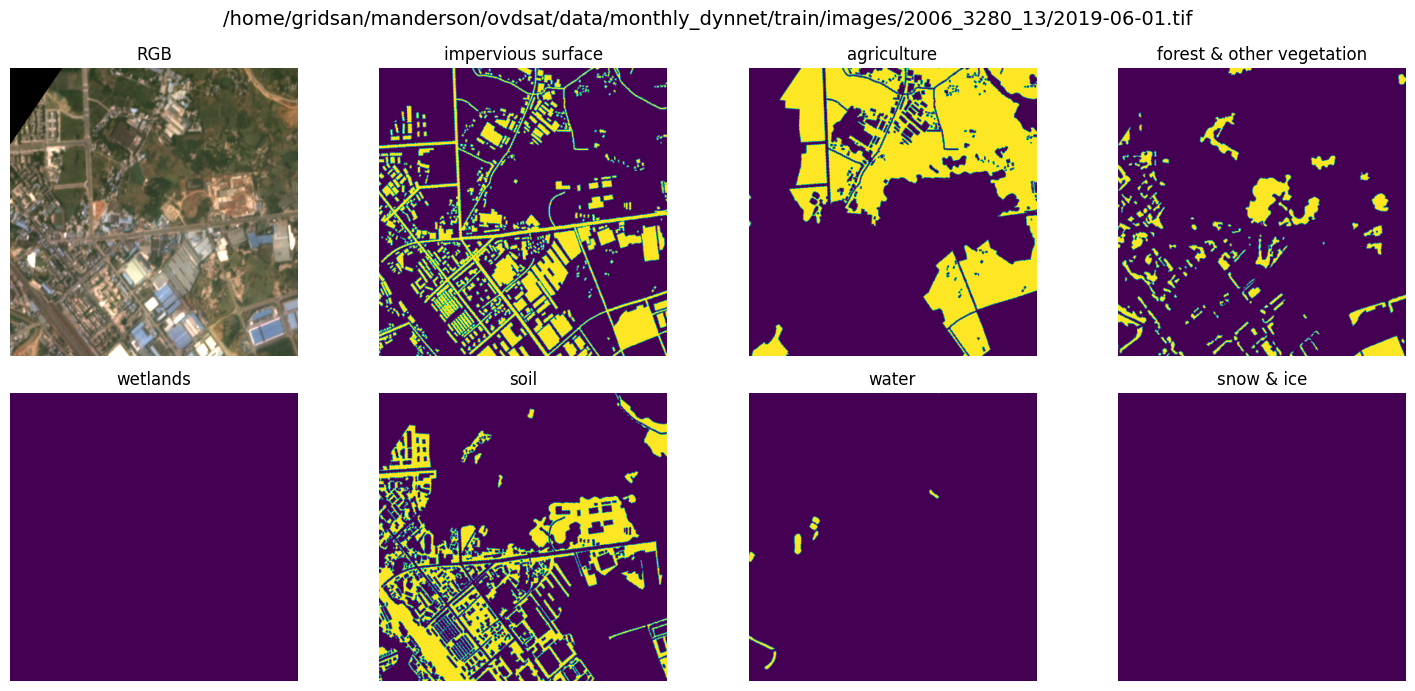

In [16]:
# Train data
rand_idx = random.randint(0, len(train_data))

img, mask = train_data[rand_idx]
#rgb = np.array(np.transpose(img[:-1,:,:], (1, 2, 0)))
rgb = np.array(np.dstack((img[2], img[1], img[0])))
norm_rgb = (rgb - rgb.min())/(rgb.max() - rgb.min())
rs_rgb = rescale(norm_rgb)

# Create a 2x4 grid for the images
fig, axes = plt.subplots(2, 4, figsize=(15, 7))  # Adjust figure size as needed

# Plot each image
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(rs_rgb)
    else:
        ax.imshow(mask[i-1])
    ax.set_title(titles[i], fontsize=12)
    ax.axis('off')  # Hide axis
    
plt.suptitle(dataobj.get_id(rand_idx)[0], fontsize=14)
plt.tight_layout()
plt.show()

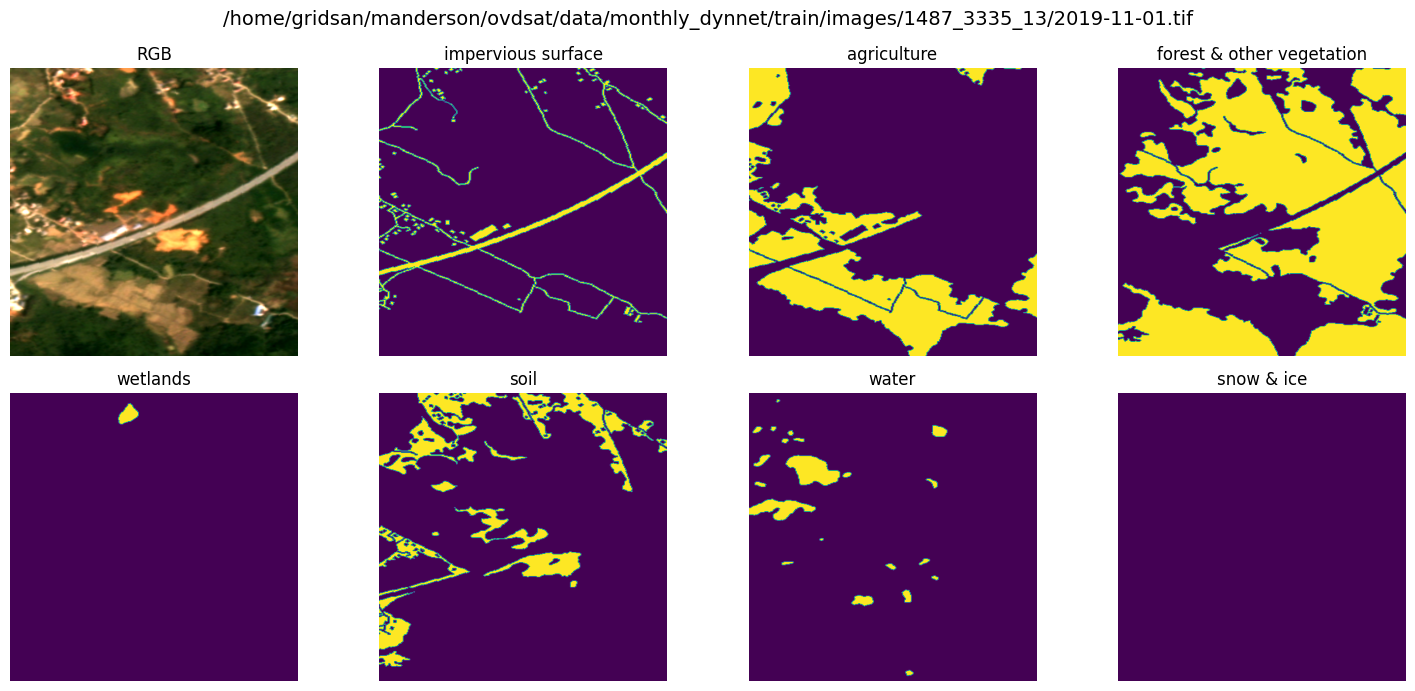

In [17]:
# Val data
rand_idx = random.randint(0, len(val_data))

img, mask = val_data[rand_idx]
#rgb = np.array(np.transpose(img[:-1,:,:], (1, 2, 0)))
rgb = np.array(np.dstack((img[2], img[1], img[0])))
norm_rgb = (rgb - rgb.min())/(rgb.max() - rgb.min())
rs_rgb = rescale(norm_rgb)

# Create a 2x4 grid for the images
fig, axes = plt.subplots(2, 4, figsize=(15, 7))  # Adjust figure size as needed

# Plot each image
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(rs_rgb)
    else:
        ax.imshow(mask[i-1])
    ax.set_title(titles[i], fontsize=12)
    ax.axis('off')  # Hide axis
    
plt.suptitle(dataobj.get_id(rand_idx)[0], fontsize=14)
plt.tight_layout()
plt.show()

### Check DynnetEval

In [9]:
test_split = '/home/gridsan/manderson/ovdsat/data/monthly_dynnet/splits/test.txt'

test_data = DynnetEval(test_split)

print(len(test_data))

print(test_data.samples[0])

480
['/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/images/1286_2921/2018-01-01.tif', '/home/gridsan/manderson/ovdsat/data/monthly_dynnet/test/labels/1286_2921/2018-01-01.tif']


### Mixing backbones and segmentation decoders

In [40]:
model = smp.Unet(classes=7, activation=None)

In [45]:
bb = load_backbone('dinov2')

Using cache found in /home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main
/home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [52]:
del model.encoder

In [53]:
print(model)

Unet(
  (decoder): UnetDecoder(
    (center): Identity()
    (blocks): ModuleList(
      (0): DecoderBlock(
        (conv1): Conv2dReLU(
          (0): Conv2d(768, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (attention1): Attention(
          (attention): Identity()
        )
        (conv2): Conv2dReLU(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (attention2): Attention(
          (attention): Identity()
        )
      )
      (1): DecoderBlock(
        (conv1): Conv2dReLU(
          (0): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0

### Check CustomSeg

In [3]:
encoder = smp.encoders.get_encoder(
    name="resnet50", 
    weights="imagenet", 
    in_channels=4
)

In [4]:
print(encoder)

ResNetEncoder(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stri